In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
import time
from pylab import *
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from skimage.util.shape import view_as_windows
from sklearn.metrics import roc_curve,roc_auc_score
from tcn import TCN, tcn_full_summary
from tensorflow.keras.layers import Dense, Conv2D, Layer, Lambda, Flatten
from tensorflow.keras import Input, Model, metrics
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib

module_path = os.path.abspath(os.path.join('..'))
project_path = os.path.abspath(os.path.join('../..'))
source = os.path.abspath(os.path.join('../../../data/LOB2VecData/Research/source'))
dest = os.path.abspath(os.path.join('../../../data/LOB2VecData/Research/destination'))

if module_path not in sys.path:
    sys.path.append(module_path)
if project_path not in sys.path:
    sys.path.append(project_path)
    
np.set_printoptions(suppress=True)
np.set_printoptions(threshold=sys.maxsize)
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17766122190057509446
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10886249477937684537
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15312507191896202745
physical_device_desc: "device: XLA_GPU device"
]


In [2]:
# Hyperparameters
cols, rows = 2, 30
num_frames = 200
input_shape = (cols, rows, 1)
vol_imb_diff = 0.1
evaluate_every = 100 # interval for evaluating on one-shot tasks
batch_size = 100
n_iter = 20000 # No. of training iterations
n_val = 250 # how many one-shot tasks to validate on
h = 30
w = 2
d = 2

In [3]:
# Data
X_train = np.load(dest + '/' + str(num_frames) + '_X.npy')
Y_train = np.load(dest + '/' + str(num_frames) + '_Y.npy')

X_test = np.load(dest + '/' + str(num_frames) + '_small_X.npy')
Y_test = np.load(dest + '/' + str(num_frames) + '_small_Y.npy')


### Model Initialisation

Text(0.5, 1.0, 'Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01')

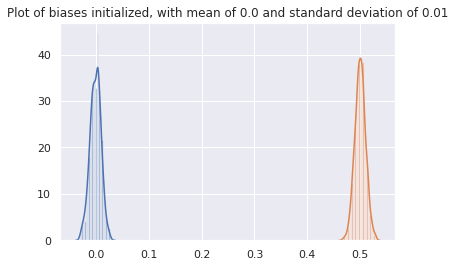

In [4]:
def initialize_weights(shape, name=None, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

def initialize_bias(shape, name=None, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

# Intialize bias with mean 0.0 and standard deviation of 10^-2
weights = initialize_weights((1000,1))
sns.distplot(weights)
plt.title("Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01")

# Intialize bias with mean 0.5 and standard deviation of 10^-2
bias = initialize_bias((1000,1))
sns.distplot(bias)
plt.title("Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01")

In [5]:
class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        p_dist = K.sum(K.square(anchor-positive), axis=-1)
        n_dist = K.sum(K.square(anchor-negative), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity 

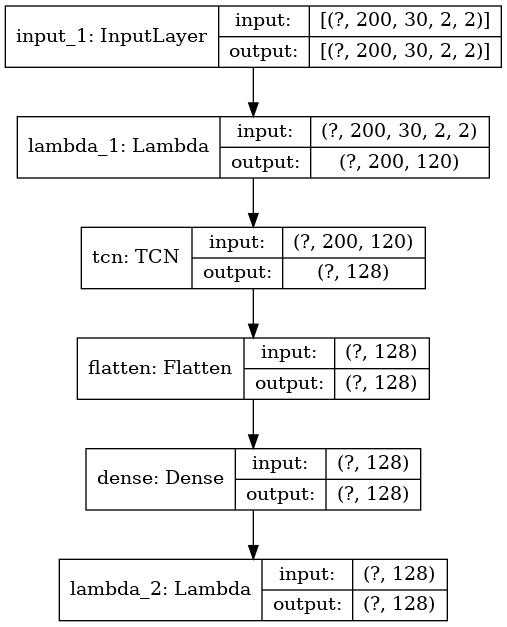

In [6]:
def embedding_model(frames, h, w, c, input_shape, dimensions, include_top=False, pooling=None):  
    inp = Input(shape=(frames, h, w, c))
    out = Lambda(lambda y: K.reshape(y, (-1, h, w, c)))(inp)
    num_features_cnn = np.prod(K.int_shape(out)[1:])
    out = Lambda(lambda y: K.reshape(y, (-1, num_frames, num_features_cnn)))(inp)
    out = TCN(nb_filters=128, kernel_size=2, return_sequences=False, dilations=[1, 2, 4, 8, 16, 32, 64], 
              activation=tf.keras.activations.swish, nb_stacks=1, dropout_rate=0.08)(out)
    out = Flatten()(out)
    out = Dense(128, activation=None, kernel_regularizer=l2(1e-3), kernel_initializer='he_uniform')(out)   
    #Force the encoding to live on the d-dimentional hypershpere
    out = Lambda(lambda x: K.l2_normalize(x,axis=-1))(out)
    return Model(inputs=inp, outputs=out)

def triplets_model(input_shape, embedding, include_top=False, pooling=None):

    anchor_input = Input(shape=input_shape, name='anchor_input')
    positive_input = Input(shape=input_shape, name='positive_input')
    negative_input = Input(shape=input_shape, name='negative_input')

    # Get the embedded values
    encoded_a = embedding(anchor_input)
    encoded_p = embedding(positive_input)
    encoded_n = embedding(negative_input)
    
    #TripletLoss Layer
    loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([encoded_a,encoded_p,encoded_n])
    # Connect the inputs with the outputs
    triplet_net = Model(inputs=[anchor_input,positive_input,negative_input],outputs=[loss_layer])
    return triplet_net

build_embedding = embedding_model(num_frames, 30, w, d, input_shape=(num_frames, 30, w, d), dimensions=60)
build_triplet = triplets_model(input_shape=(num_frames, 30, w, d), embedding=build_embedding)
optimizer = Adam(lr = 0.00006)
build_triplet.compile(loss=[None],optimizer=optimizer,sample_weight_mode="temporal")
build_embedding.summary()
build_triplet.summary()
#print(build_triplet.metrics_names)
tcn_full_summary(build_embedding, expand_residual_blocks=True)
plot_model(build_embedding, 'multi_input_and_output_model.png', show_shapes=True)

In [7]:
def get_triplet_batch_spoof(batch_size, lob_states, labels):
    n_examples, t, h, w, d = lob_states.shape
    triplets = [np.zeros((batch_size, t, h, w, d)) for i in range(3)]

    for i in range(batch_size):
        idx_a = np.random.choice(labels.shape[0], 1, replace=False)
        idx_p = np.random.choice([i for i, v in enumerate(labels) if v == labels[idx_a]], 1, replace=False)
        idx_n = np.random.choice([i for i, v in enumerate(labels) if v != labels[idx_a]], 1, replace=False)
        
        triplets[0][i,:,:,:,:] = lob_states[idx_a]
        triplets[1][i,:,:,:,:] = lob_states[idx_p]
        triplets[2][i,:,:,:,:] = lob_states[idx_n]
        
    return [triplets[0], triplets[1], triplets[2]]

def triplet_generator_spoof(batch_size, X_train, Y_train):
    while True:
        triplets = get_triplet_batch_spoof(batch_size, X_train, Y_train)
        yield triplets

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[ 0.14763401 -0.03729962 -0.09436139 -0.02307667  0.03632715 -0.11745016
 -0.05852642  0.04168737 -0.1106884   0.08289228 -0.03348817 -0.14787166
  0.02989216 -0.07006649 -0.09719639 -0.20136556  0.10956576  0.00091523
  0.13916966 -0.15154777 -0.08431951 -0.03326864 -0.06220835 -0.04716126
  0.09900807  0.06197229  0.00241627 -0.00413908  0.08818679  0.05484698
 -0.07153886  0.0916798

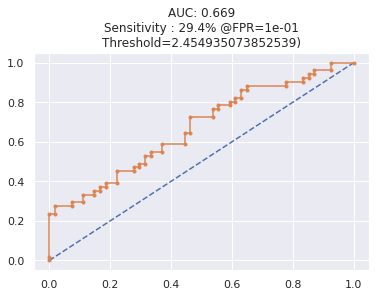

In [8]:
from scipy.spatial import distance

def compute_dist(a,b):
    return distance.cityblock(a,b)
    #return distance.correlation(a,b) -- NOT GOOD
    #return distance.cosine(a,b) -- NOT GOOD
    
    #return distance.euclidean(a,b)

    # Standard distance used 
    #return np.sum(np.square(a-b))

def compute_metrics(probs, yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no 
        instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
   
    return fpr, tpr, thresholds, auc

def compute_interdist(network):
    '''
    Computes sum of distances between all classes embeddings on our reference test image: 
        d(0,1) + d(0,2) + ... + d(0,9) + d(1,2) + d(1,3) + ... d(8,9)
        A good model should have a large distance between all theses embeddings
        
    Returns:
        array of shape (nb_classes,nb_classes) 
    '''
    res = np.zeros((nb_classes,nb_classes))
    
    ref_images = np.zeros((nb_classes, num_frames, rows, cols, d))
    
    #generates embeddings for reference images
    for i in range(nb_classes):
        ref_images[i,:,:,:] = X_test[i,:,:,:,:]
    ref_embeddings = network.predict(ref_images)
    
    for i in range(nb_classes):
        for j in range(nb_classes):
            res[i,j] = compute_dist(ref_embeddings[i],ref_embeddings[j])
    return res

def draw_interdist(network, n_iteration):
    interdist = compute_interdist(network)
    
    data = []
    for i in range(nb_classes):
        data.append(np.delete(interdist[i,:],[i]))

    fig, ax = plt.subplots()
    ax.set_title('Evaluating embeddings distance from each other after {0} iterations'.format(n_iteration))
    ax.set_ylim([0,3])
    plt.xlabel('Classes')
    plt.ylabel('Distance')
    ax.boxplot(data,showfliers=False,showbox=True)
    locs, labels = plt.xticks()
    plt.xticks(locs,np.arange(nb_classes))
    plt.show()
    
def find_nearest(array, value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx
    
def draw_roc(fpr, tpr,thresholds, auc):
    #find threshold
    targetfpr=0.1
    _, idx = find_nearest(fpr, targetfpr)
    threshold = thresholds[idx]
    recall = tpr[idx]
    
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title('AUC: {0:.3f}\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc,targetfpr,recall,abs(threshold)))
    # show the plot
    #plt.show()
    plt.savefig('Run1.png')
    
def compute_probs(network, X, Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m, num_frame, h, w, 1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    print(embeddings[1])
    
    size_embedding = embeddings.shape[1]
    
    #For each pics of our dataset
    k = 0
    for i in range(m):
            #Against all other images
            for j in range(i+1,m):
                #compute the probability of being the right decision : it should be 1 for 
                # right class, 0 for all other classes
                probs[k] = -compute_dist(embeddings[i,:],embeddings[j,:])
               # print(probs[k])
                if (Y[i]==Y[j]):
                    y[k] = 1
                    #print("{3}:{0} vs {1} : {2}\tSAME".format(i,j,probs[k],k))
                else:
                    y[k] = 0
                   # print("{3}:{0} vs {1} : \t\t\t{2}\tDIFF".format(i,j,probs[k],k))
                k += 1
    return probs, y
#probs,yprobs = compute_probs(network,x_test_origin[:10,:,:,:],y_test_origin[:10])

class call_back(tf.keras.callbacks.Callback):
    probs, yprob = compute_probs(build_embedding, X_test, Y_test)
    fpr, tpr, thresholds, auc = compute_metrics(probs, yprob)
    draw_roc(fpr, tpr, thresholds, auc)
   # draw_interdist(build_embedding, n_iteration)

In [ ]:
history = build_triplet.fit(x=triplet_generator_spoof(batch_size, X_train, Y_train), y=None, batch_size=batch_size, epochs=5, verbose=1, callbacks=None, 
                              validation_data=None, shuffle=True, class_weight=None, 
                              sample_weight=None, initial_epoch=0, steps_per_epoch=100, validation_steps=None)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
100/100 [==============================] - 16195s 162s/step - loss: 14.9039
Epoch 2/5
100/100 [==============================] - 16488s 165s/step - loss: 10.1013
Epoch 3/5
100/100 [==============================] - 16069s 161s/step - loss: 9.5013
Epoch 4/5
100/100 [==============================] - 15538s 155s/step - loss: 8.8359
Epoch 5/5
  9/100 [=>.........................

In [ ]:
probs, yprob = compute_probs(build_embedding, X_test[:500,:,:,:,:], Y_test[:500])
fpr, tpr, thresholds, auc = compute_metrics(probs, yprob)
draw_roc(fpr, tpr, thresholds, auc)

In [9]:
n_iter = 2000
def train_my_network():
    print("Starting training process!!")
    print("-------------------------------------")
    t_start = time.time()
    n_iteration=0
    #dummy_target = [np.zeros((batch_size,15)) for i in range(3)]
    for i in range(1, n_iter+1):
        train_gen = get_triplet_batch_spoof(batch_size, X_train, Y_train)
        val_gen = get_triplet_batch_spoof(batch_size, X_test, Y_test)
        loss = build_triplet.fit_generator(train_gen, verbose=1)
        n_iteration += 1
        if i % 100 == 0:
            print("\n ------------- \n")
            print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}"\
                  .format(i, (time.time()-t_start)/60.0,loss,n_iteration))
            probs, yprob = compute_probs(build_embedding, X_test[:500,:,:,:,:], Y_test[:500])
            fpr, tpr, thresholds, auc = compute_metrics(probs, yprob)
            draw_roc(fpr, tpr, thresholds, auc)
            draw_interdist(build_embedding, n_iteration)
           # print("Probability " + str(probs))
           # print("YProbs " + str(yprob))
            #fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
            #draw_roc(fpr, tpr)

train_my_network()

Starting training process!!
-------------------------------------
Instructions for updating:
Please use Model.fit, which supports generators.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


KeyboardInterrupt: 